In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from Utils import utils
warnings.filterwarnings('ignore')

In [2]:
tickers = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X']
dl_tickers = False
if dl_tickers:
    download_tickers('CSVData', tickers)

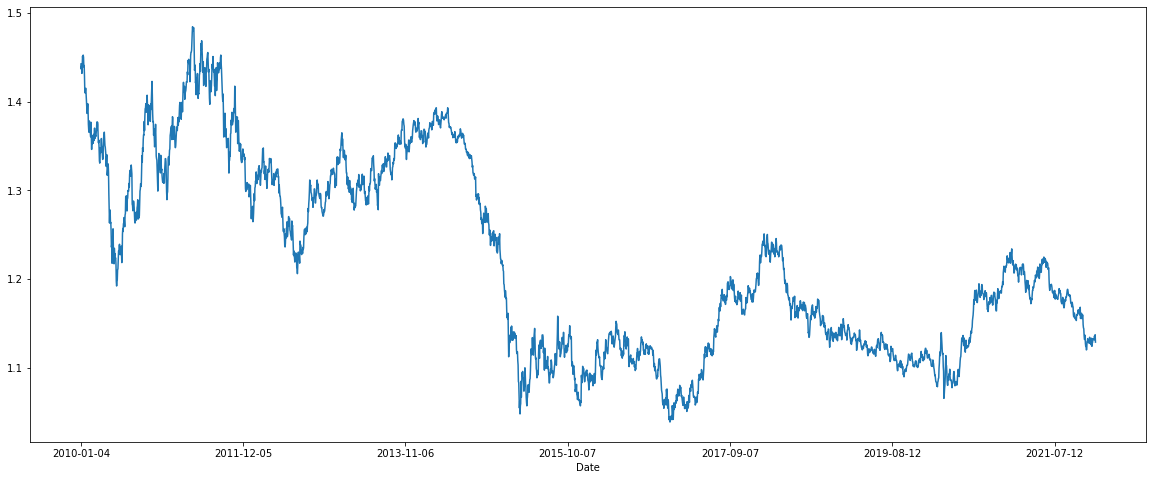

In [3]:
folder, ticker, period = 'CSVData', 'EURUSD=X', 'daily'
ohlcv = pd.read_csv(folder+'/'+ticker+'_12y_'+period+'.csv').set_index('Date')
multiplier = 100 if 'JPY' in ticker else 10000
pyplot.figure(figsize=(20,8))
ohlcv['Close'].plot()
pyplot.show()

In [4]:
ohlcv['Median'] = (ohlcv['High'] + ohlcv['Low'])/2

In [ ]:
# optional
ohlcv = ohlcv[ohlcv.index > '2015-01-01']

In [6]:
##
label = 'Close'
n = 8
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
##

In [ ]:
rsi14  = ta.momentum.rsi(ohlcv[label], window=14, fillna=False)
mv3 = ohlcv[label].rolling(window=3).mean().shift(periods=1)
mv5 = ohlcv[label].rolling(window=5).mean().shift(periods=1)
mv8 = ohlcv[label].rolling(window=8).mean().shift(periods=1)
mv20 = ohlcv[label].rolling(window=20).mean().shift(periods=1)

In [ ]:
X = pd.concat([mv3, mv8, mv20], axis=1)[n:]
y = ohlcv[[label]].iloc[n:]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
                    max_iter=1000, n_iter_no_change=500, verbose=False)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mean_absolute_error(predicted, y_test), mean_absolute_percentage_error(predicted, y_test)

(0.0054373284607839795, 0.004742965788922508)

In [13]:
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
print('Average candle range: ' + str(sum(abs(ohlcv_test['High']-ohlcv_test['Low']))*multiplier/len(diff)) + ' pips')
ohlcv_test

Average candle range: 62.50586838294299 pips


,Open,High,Low,Close,Adj Close,Volume,Median
Date,,,,,,,
2019-08-15,1.114504,1.115900,1.109558,1.114330,1.114330,0,1.112729
2019-08-16,1.111136,1.111358,1.106746,1.111358,1.111358,0,1.109052
2019-08-19,1.109385,1.111000,1.108820,1.109385,1.109385,0,1.109910
2019-08-20,1.108254,1.109900,1.106893,1.108316,1.108316,0,1.108396
2019-08-21,1.109853,1.110741,1.108881,1.109779,1.109779,0,1.109811
...,...,...,...,...,...,...,...
2021-12-29,1.131337,1.137001,1.127536,1.131478,1.131478,0,1.132268
2021-12-30,1.135976,1.135976,1.130071,1.136015,1.136015,0,1.133024
2021-12-31,1.132323,1.137915,1.130506,1.132503,1.132503,0,1.134210


In [ ]:
plt.plot(abs(diff)*multiplier)

In [ ]:
ohlcv['candleRange'] = np.nan
for i in range(0,len(ohlcv)):
    ohlcv['candleRange'][i] = (ohlcv['High'][i] - ohlcv['Low'][i])*10E3
    
#print(np.nansum(ohlcv['candleRange'])/len(ohlcv['candleRange']))
print(np.nansum(ohlcv['candleRange'].mean()))
print(np.nansum(ohlcv['candleRange'].std()))
plt.figure(figsize=(20,8))
ohlcv['candleRange'].plot()

In [ ]:
regr = XGBRegressor(n_estimators=300, max_depth=6)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

print('Average diff: ' + str(sum(abs(diff))*multiplier/len(diff)) + ' pips')

In [ ]:
regr = RandomForestRegressor(n_estimators = 200)
regr.fit(X_train, y_train.to_numpy().ravel())

predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

print('Average diff: ' + str(sum(abs(diff))*multiplier/len(diff)) + ' pips')

In [14]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred

,y_pred,low,high,open,close
Date,,,,,
2019-08-15,1.115020,1.109558,1.115900,1.114504,1.114330
2019-08-16,1.111131,1.106746,1.111358,1.111136,1.111358
2019-08-19,1.108343,1.108820,1.111000,1.109385,1.109385
2019-08-20,1.105874,1.106893,1.109900,1.108254,1.108316
2019-08-21,1.104364,1.108881,1.110741,1.109853,1.109779
...,...,...,...,...,...
2021-12-29,1.127991,1.127536,1.137001,1.131337,1.131478
2021-12-30,1.127679,1.130071,1.135976,1.135976,1.136015
2021-12-31,1.129979,1.130506,1.137915,1.132323,1.132503


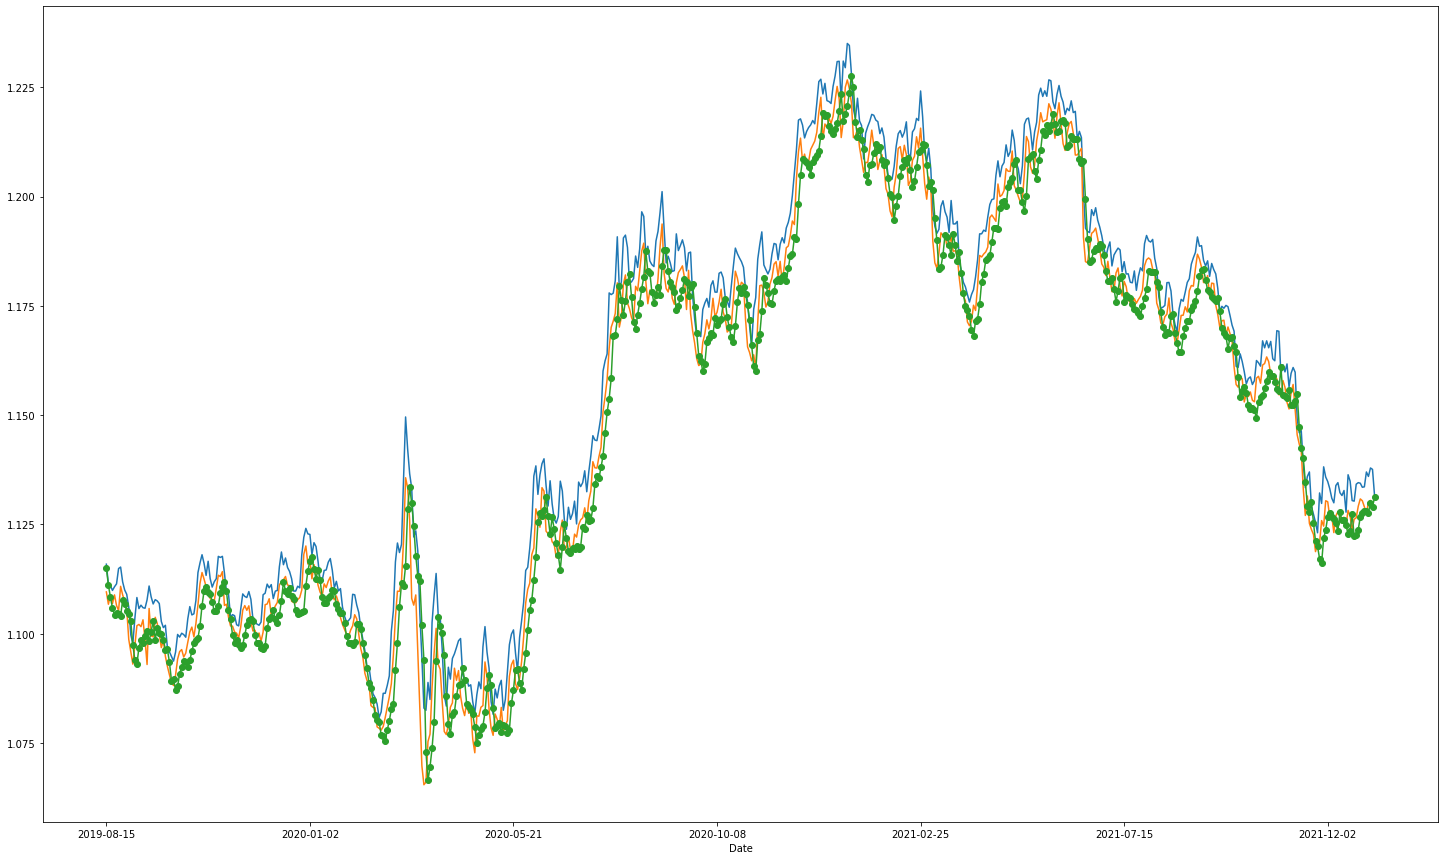

Hitrate: 29.33%
Number of candles: 624


In [15]:
y_pred, hitrate = utils.get_hitrate(y_pred)
pyplot.figure(figsize=(25,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
pyplot.show()
print('Hitrate: ' + str(round(hitrate*100,2)) + '%')
print('Number of candles: ' + str(len(y_pred)))

In [16]:
y_pred, direction = utils.get_direction(y_pred)
y_pred, OR = utils.get_OR(y_pred)
y_pred, pips = utils.get_pips(y_pred, multiplier)
print('Direction: ' + str(round(direction*100,2)) + '%')
print('OR: ' + str(round(OR*100,2)) + '%')
print('Total pips: ' + str(round(pips,2)))

Direction: 45.19%
OR: 59.62%
Total pips: 4311.73


In [18]:
sum(y_pred[y_pred['pips']>=0]['pips'])

4714.639109667269

In [17]:
y_pred['pips'].to_list()

[5.157675544245066,
 0.05085205889709954,
 0.0,
 -0.6151199340820312,
 0.7390975952126233,
 -0.3695487976074219,
 -0.7367134094238281,
 0.0,
 -2.5892257690429688,
 0.0,
 -0.49114227294921875,
 13.57628734706795,
 0.8451938629128186,
 6.618076946347529,
 -0.9632110595703125,
 2.557039260864258,
 0.0,
 0.12159347534179688,
 -1.0991096496604236,
 55.259969038152775,
 8.187232888325902,
 -0.6115436553932874,
 80.16683367843225,
 25.58074332772886,
 -0.3671646118186267,
 0.0,
 44.517579514096184,
 19.415658365240507,
 7.633008344765102,
 51.895763753302404,
 12.271785851503125,
 11.12225165416758,
 49.12780379797255,
 2.7132978719879297,
 0.4780292510986328,
 -1.6820430755659643,
 -0.48160552978515625,
 0.0,
 0.6020069122292249,
 0.11920928954634036,
 -1.9323825836203845,
 3.396272659301758,
 -1.8489360809303967,
 -3.1614303588867188,
 -0.7307529449440686,
 -0.6377696990966797,
 0.0,
 0.3731250762939453,
 0.247955322265625,
 0.37193298339621705,
 37.70081705318562,
 12.488346803929407,
 0.4

In [ ]:
#next: test keeping false positions open